# Requirements

In [111]:
import pandas as pd
import numpy as np
import requests
import re
import json
import random
import scipy

import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch

from nltk import ngrams

import seaborn as sns
import geoplot as gplt

import warnings
warnings.filterwarnings('ignore')

import sddk
import tempun

In [2]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Import the dataset

In [3]:
EDHCS = pd.read_csv("../data/large_data/EDHCS_occupsorgs.csv", low_memory=False, index_col=None)
EDHCS["geometry"] = EDHCS["geometry"].apply(eval)
EDHCSg = gpd.GeoDataFrame(EDHCS, geometry=gpd.points_from_xy(EDHCS["geometry"].apply(lambda x: x[0]), EDHCS["geometry"].apply(lambda x: x[1]))) #, crs={"init": "epsg:3857"})

# Exploring durations

In [4]:
def get_duration(start, stop):
  try:
    duration = abs(int(start) - int(stop)) + 1
    if 0 in range(int(start),  int(stop)):
      duration = duration - 1
  except:
    duration = np.nan
  return duration

EDHCSg["duration"] = EDHCSg.apply(lambda row: get_duration(row["not_before"], row["not_after"]), axis=1)

CPU times: user 195 ms, sys: 4.93 ms, total: 200 ms
Wall time: 198 ms


(-5.0, 305.0)

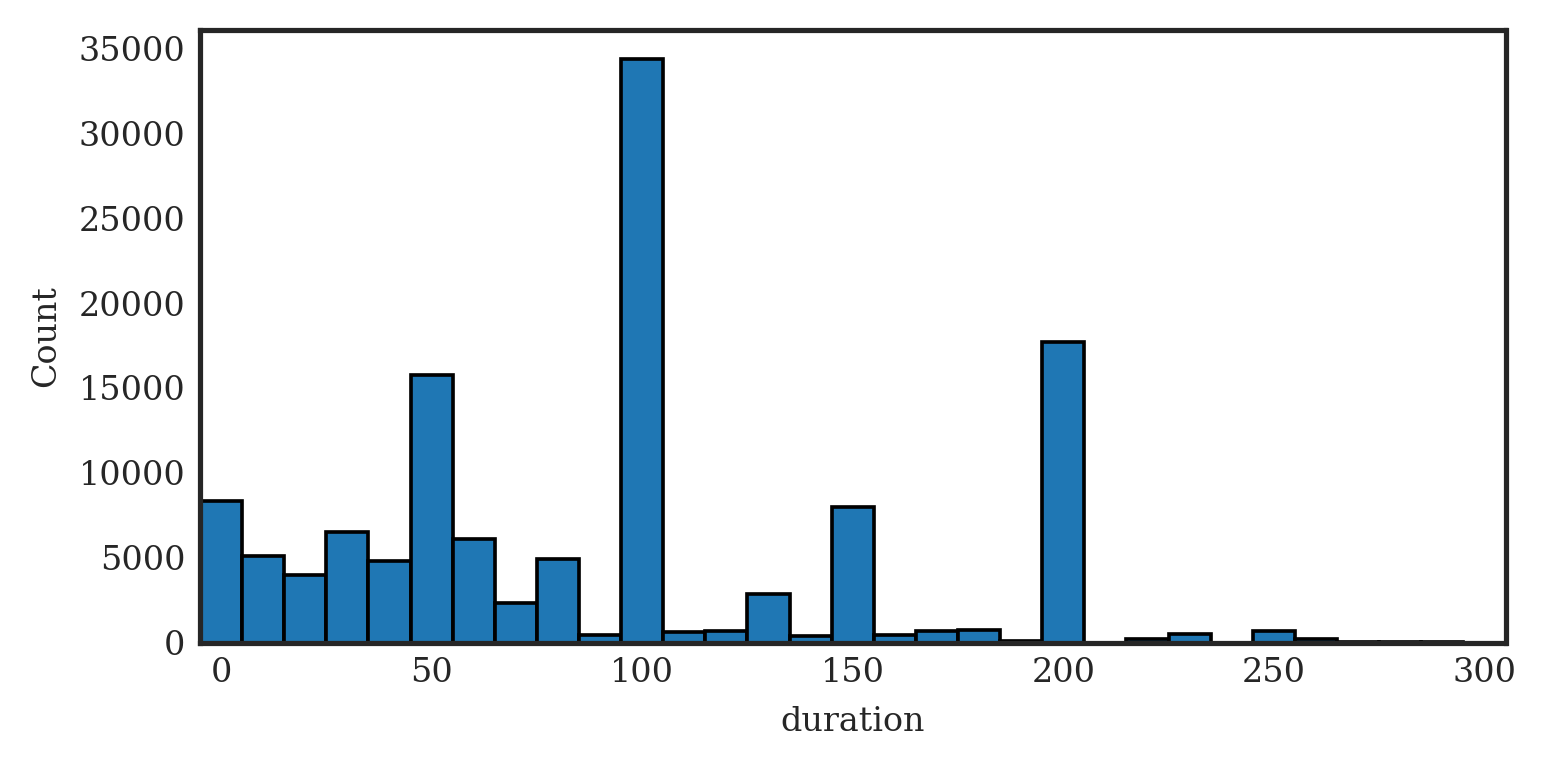

In [11]:
%%time 
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.2, 2.6), tight_layout=True)
sns.histplot(EDHCSg["duration"], kde=False, bins=range(-5, 305,10), alpha=1, color="tab:blue", ax=ax)
ax.set_xlim(-5, 305)

In [14]:
fig.savefig("../figures/durations_histogram.eps", format="eps", dpi=300)

In [43]:
figpath = "SDAM_data/social_diversity/socdiv_figures/"
sddk.write_file(figpath + "durations_histogram.eps", fig, conf)

In [16]:
len(EDHCSg)

136190

In [17]:
durations_df = pd.DataFrame(EDHCSg.groupby("duration").size().sort_values(ascending=False))
durations_df.reset_index(inplace=True)
durations_df = durations_df.astype(int)
durations_df.columns = ["duration", "count"]
durations_df["pct"] = np.round((durations_df["count"] / len(EDHCSg)) * 100, 2)
durations_df.head(20)

,duration,count,pct
0,100,33920,24.91
1,200,17658,12.97
2,50,15102,11.09
3,150,7542,5.54
4,300,5343,3.92
5,60,5176,3.80
6,1,4332,3.18
7,30,3471,2.55
8,40,2675,1.96
9,130,2652,1.95


In [79]:
durations_df.to_csv("../data/durations_table.csv")

# Random dates and overall simulations

In [26]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
EDHCSg["random_dates"] = EDHCSg.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 1min 13s, sys: 1.63 s, total: 1min 14s
Wall time: 1min 14s


In [27]:
%%time
EDHCS_complete_simulations = tempun.timeblocks_from_randoms(EDHCSg, "random_dates", [-50, 350, 50])

CPU times: user 7.79 s, sys: 44 ms, total: 7.84 s
Wall time: 7.84 s


In [28]:
EDHCS_complete_simulations[0]

[((-50, -1), 5310),
 ((1, 50), 20242),
 ((51, 100), 20113),
 ((101, 150), 22083),
 ((151, 200), 21827),
 ((201, 250), 18004),
 ((251, 300), 9681),
 ((301, 350), 8110)]

In [29]:
EDHCS_complete_merged = tempun.simulations_merged(EDHCS_complete_simulations)

In [30]:
len(EDHCS_complete_merged)

8

In [32]:
print(EDHCS_complete_merged[0][:50])

((-50, -1), [5310, 5215, 5215, 5271, 5237, 5308, 5275, 5190, 5285, 5256, 5264, 5253, 5270, 5254, 5186, 5178, 5180, 5275, 5293, 5241, 5284, 5280, 5245, 5245, 5333, 5246, 5203, 5272, 5227, 5249, 5214, 5244, 5227, 5208, 5255, 5316, 5253, 5284, 5269, 5286, 5272, 5288, 5263, 5255, 5291, 5302, 5270, 5178, 5334, 5254, 5236, 5190, 5286, 5264, 5284, 5259, 5278, 5271, 5266, 5283, 5282, 5229, 5168, 5292, 5253, 5223, 5228, 5302, 5300, 5243, 5285, 5278, 5317, 5240, 5220, 5313, 5264, 5323, 5268, 5250, 5229, 5275, 5272, 5309, 5269, 5216, 5263, 5232, 5231, 5293, 5264, 5246, 5169, 5188, 5290, 5257, 5252, 5194, 5279, 5217])


# Comparing distributions by means of KDE

In [68]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudian" : {"startdate": -27, "enddate" : 68},
    "Flavian" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 192},
    "Severan" : {"startdate": 193, "enddate": 235},
    "Barracks emperors" : {"startdate" : 236, "enddate" : 284},
    "Tetrarchy\n& Constantine I" : {"startdate" : 285, "enddate" : 337}
    }
timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 68), (69, 96), (97, 192), (193, 235), (236, 284), (285, 337)]

In [79]:
colors_list = [color for color in list(mcolors.CSS4_COLORS.keys()) if "light" in color][2:]
colors_list

['lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 'lightgreen',
 'lightgrey',
 'lightpink',
 'lightsalmon',
 'lightseagreen',
 'lightskyblue',
 'lightslategray',
 'lightslategrey',
 'lightsteelblue',
 'lightyellow']

In [69]:
periods_duration = [abs(tup[1] - tup[0]) for tup in timeblocks_periods]
periods_duration

[95, 27, 95, 42, 48, 52]

In [70]:
%%time
var_data_edhcs = []
for var_n in range(1000):
    var_data_edhcs.append([var[var_n] for var in EDHCSg["random_dates"] if var !=None])

CPU times: user 55 s, sys: 17.7 ms, total: 55 s
Wall time: 55 s


In [71]:
%%time
sim_big = tempun.timeblocks_from_randoms(EDHCSg[EDHCSg["urban_context"]=="big"], "random_dates", [-50, 350, 50])
sim_middle = tempun.timeblocks_from_randoms(EDHCSg[EDHCSg["urban_context"]=="middle"], "random_dates", [-50, 350, 50])
sim_rest = tempun.timeblocks_from_randoms(EDHCSg[EDHCSg["urban_context"]=="rest"], "random_dates", [-50, 350, 50])

CPU times: user 5.18 s, sys: 34.3 ms, total: 5.22 s
Wall time: 5.22 s


CPU times: user 18min, sys: 16min 40s, total: 34min 40s
Wall time: 8min 42s


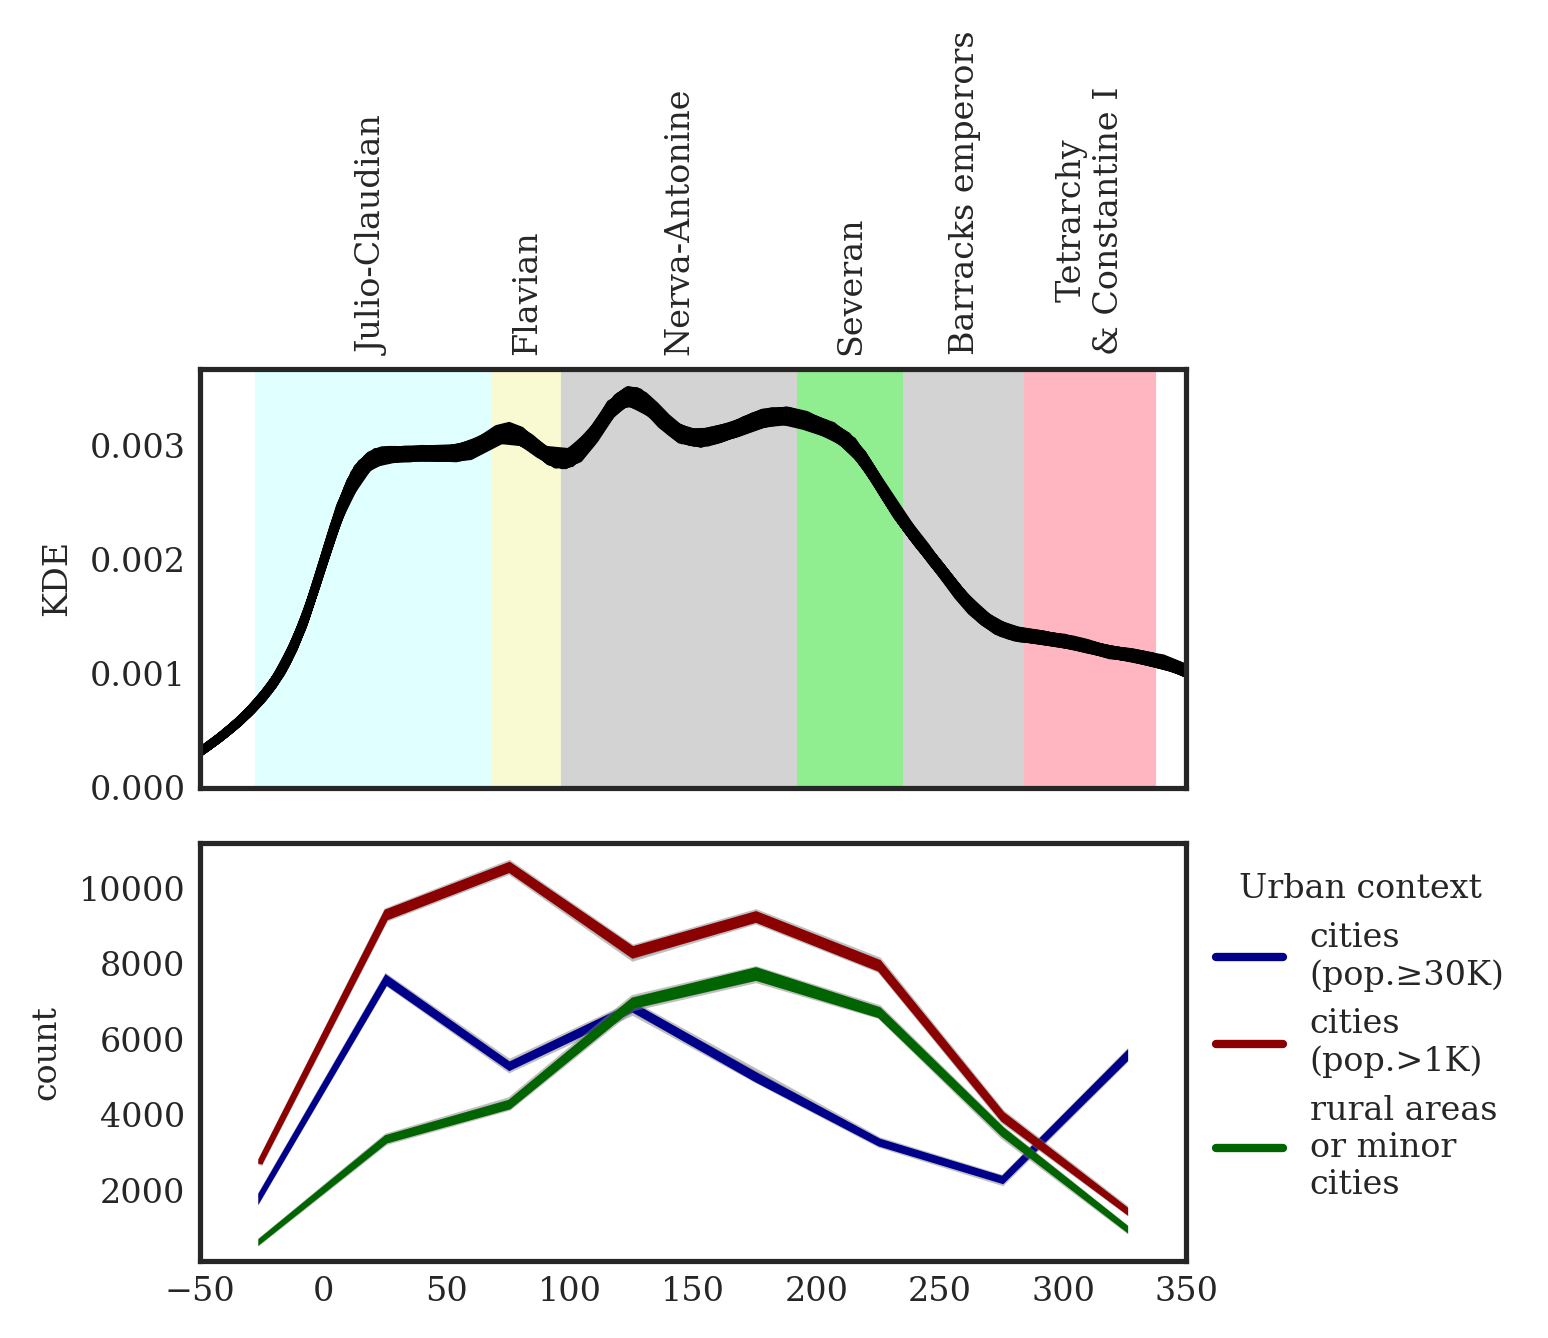

In [81]:
%%time 
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

fig, [ax1, ax2] = plt.subplots(2,1, figsize=[5.2,4.5], tight_layout=True)

# ax1 - EDH KDE plot
for data in var_data_edhcs[:1000]:
    sns.kdeplot(data, ax=ax1, color="black")   

for period, color in zip(periods.keys(), colors_list):
    ax1.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")
ax1.set_xlim(-50,350)
# period labels
ax1.set_xticks(positions)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
ax1.set_ylabel("KDE")

# ax2 - timeblocks
tempun.plot_timeblocks_data(sim_big, color="darkblue", ax=ax2)
tempun.plot_timeblocks_data(sim_middle, color="darkred", ax=ax2)
tempun.plot_timeblocks_data(sim_rest, color="darkgreen", ax=ax2)
ax2.set_ylabel("count")
ax2.set_xlim(-50,350)

legend_labels=[
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural areas\nor minor\ncities"]

colors=["darkblue", "darkred", "darkgreen"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax2.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(1, 1), loc='upper left')

In [82]:
sddk.write_file(figpath + "temporal_distribution_by_context.png", fig, conf)
sddk.write_file(figpath + "temporal_distribution_by_context.eps", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_by_context.png"
A file with the same name ("temporal_distribution_by_context.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_by_context.eps"


# Spatial dissemination of inscriptions

In [46]:
def get_date_var(randoms):
    try: return randoms[0]
    except: return None
EDHCSg["date_var_1"] = EDHCSg["random_dates"].apply(get_date_var)

In [47]:
def date_to_str(date):
    if date < 0:
        date = str(abs(date)) + "BC"
    else: 
        date = str(date) + "AD"
    return date

periods_labels = []
for period in periods.keys():
    start = date_to_str(periods[period]["startdate"])
    end = date_to_str(periods[period]["enddate"])
    periods_labels.append(period + " ({0}-{1})".format(start, end))
periods_labels

['Julio-Claudian (27BC-68AD)',
 'Flavian (69AD-96AD)',
 'Nerva-Antonine (97AD-192AD)',
 'Severan (193AD-235AD)',
 'Barracks emperors (236AD-284AD)',
 'Tetrarchy\n& Constantine I (285AD-337AD)']

In [48]:
### # pelagios provinces - only for plotting purposes
pleiades_regions = gpd.read_file('../data/pleiades_regions.geojson', driver='GeoJSON')

In [49]:
edhcs_df_by_periods = []

for period in timeblocks_periods:
    edhcs_sample = EDHCSg[EDHCSg["date_var_1"].between(period[0], period[1])]
    edhcs_df_by_periods.append(edhcs_sample)

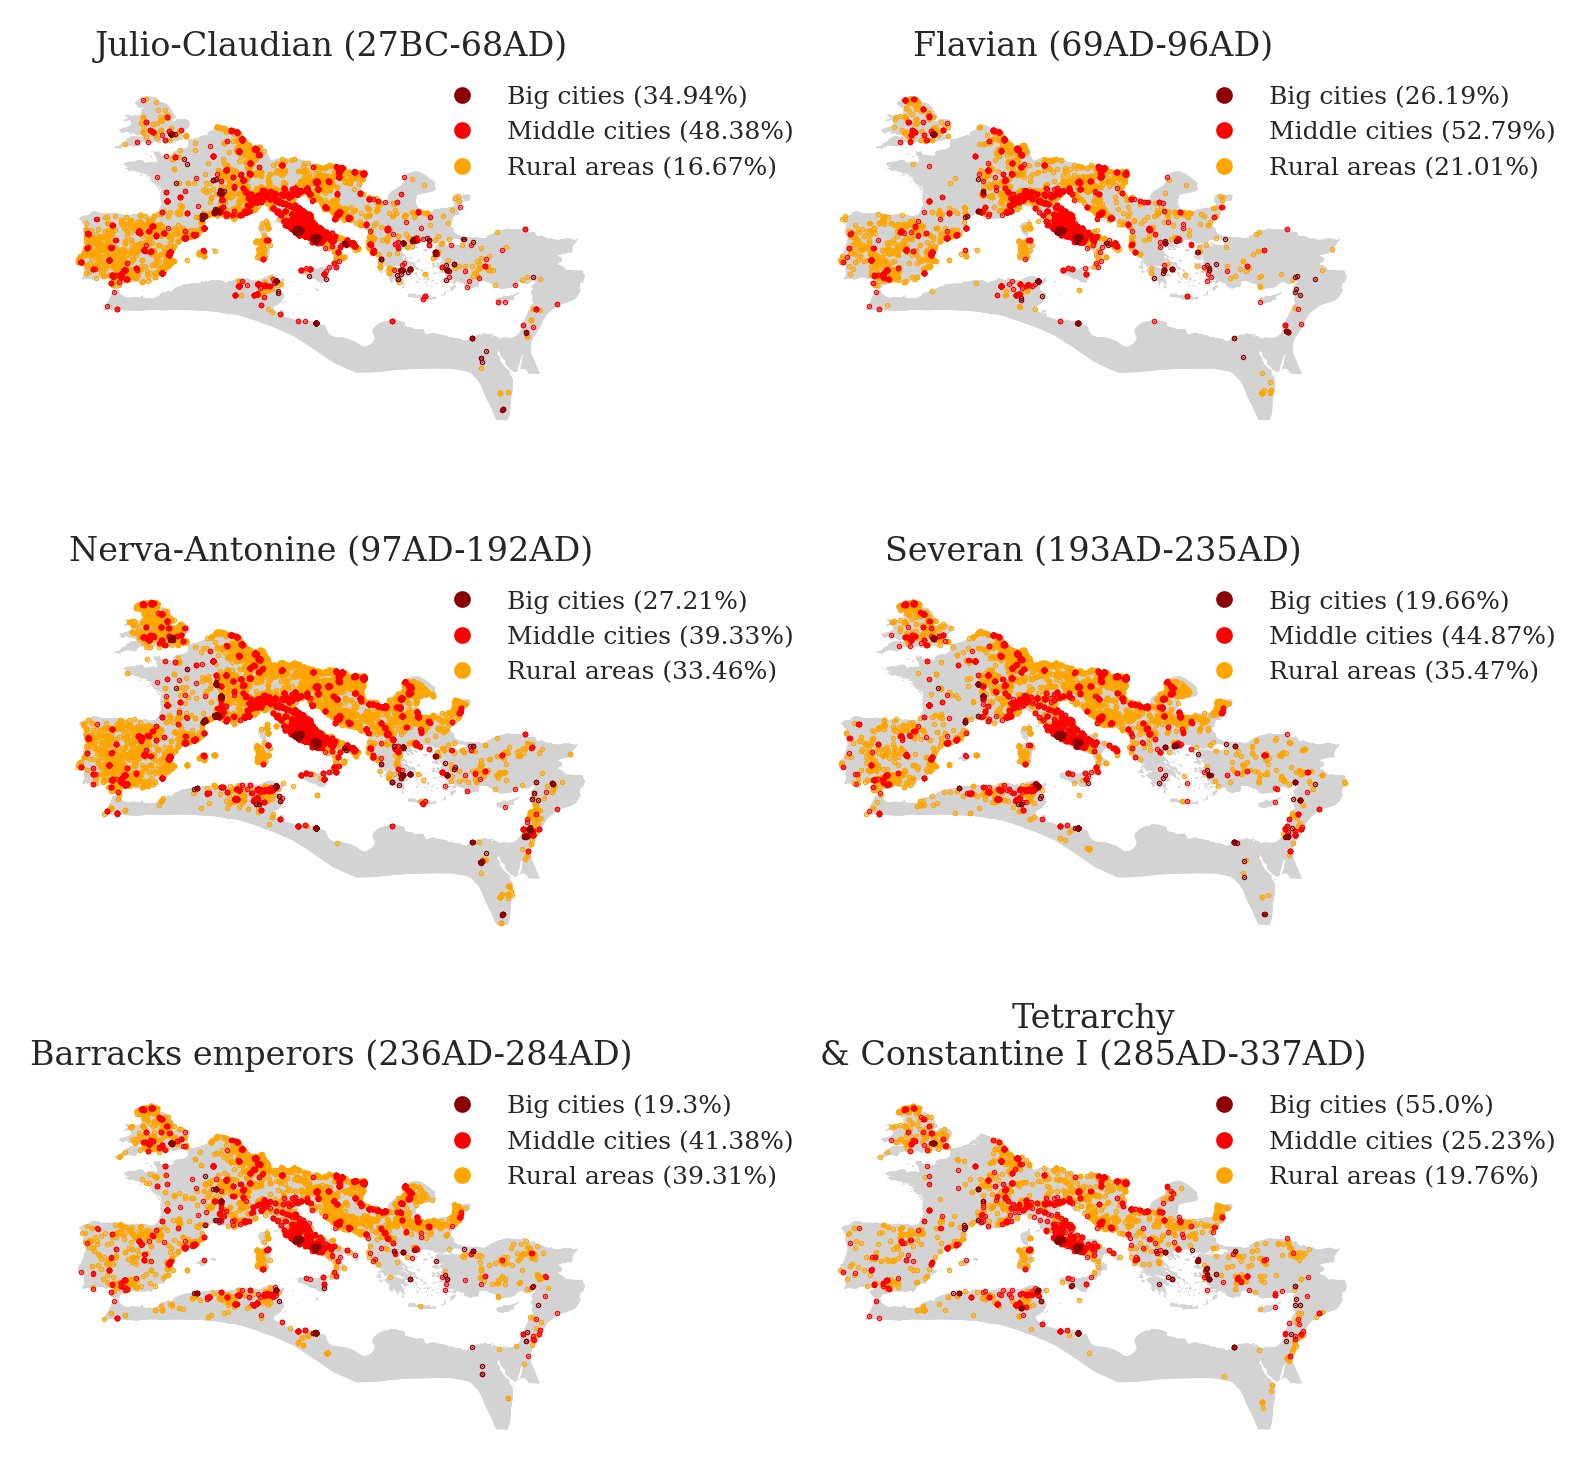

In [83]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, axs  = plt.subplots(3, 2, figsize=(5.2, 5.2), tight_layout=True)

contexts_pct = {}

for df, ax, period in zip(edhcs_df_by_periods, axs.ravel(), periods_labels):
    pleiades_regions.plot(ax=ax, color="lightgray")
    #gplt.kdeplot(df, cmap='Reds', shade=True, thresh=0.05, alpha=0.5, ax=ax)
    for context, color in [("rest", "orange"), ("middle", "red"), ("big", "darkred")]:
        df_context = df[df["urban_context"]==context]
        contexts_pct[context] = str(np.round(((len(df_context) / len(df)) * 100), 2)) + "%"
        df_context.plot(markersize=0.1, color=color, ax=ax)
    ax.set_title(period, fontsize=8)
    ax.set_axis_off()
    markers = [plt.Line2D([0,0],[0,0],color=color, marker=".", linestyle="") for color in ["darkred", "red", "orange"]]
    legend_labels = ["Big cities ({0})".format(contexts_pct["big"]), "Middle cities ({0})".format(contexts_pct["middle"]), "Rural areas ({0})".format(contexts_pct["rest"])]
    ax.legend(markers, legend_labels, numpoints=1, bbox_to_anchor=(0.65, 1.05), loc='upper left', fontsize=6)

plt.subplots_adjust(wspace=0, hspace=0)

In [85]:
fig.savefig("../figures/spatial_distribution_tempo.eps", format="eps", dpi=300)

In [84]:
sddk.write_file(figpath + "spatial_distribution_tempo.eps", fig, conf)
sddk.write_file(figpath + "spatial_distribution_tempo.png", fig, conf)

A file with the same name ("spatial_distribution_tempo.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/spatial_distribution_tempo.eps"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/spatial_distribution_tempo.png"


# Occupations and organizations over time

In [52]:
var_data_occups, var_data_orgs = [], []
for var_n in range(1000):
    var_data_occups.append([var[var_n] for var in EDHCSg[EDHCSg["occups_N"] > 0]["random_dates"] if var !=None])
    var_data_orgs.append([var[var_n] for var in EDHCSg[EDHCSg["organizations_N"] > 0]["random_dates"] if var !=None])

In [53]:
print(len(var_data_occups[0]))
print(len(var_data_orgs[0]))

3256
1182


In [56]:
sample_size = len(var_data_orgs[0]) # + len(var_data_orgs[0])
sample_size

1182

CPU times: user 55.2 s, sys: 92.5 ms, total: 55.3 s
Wall time: 55.1 s


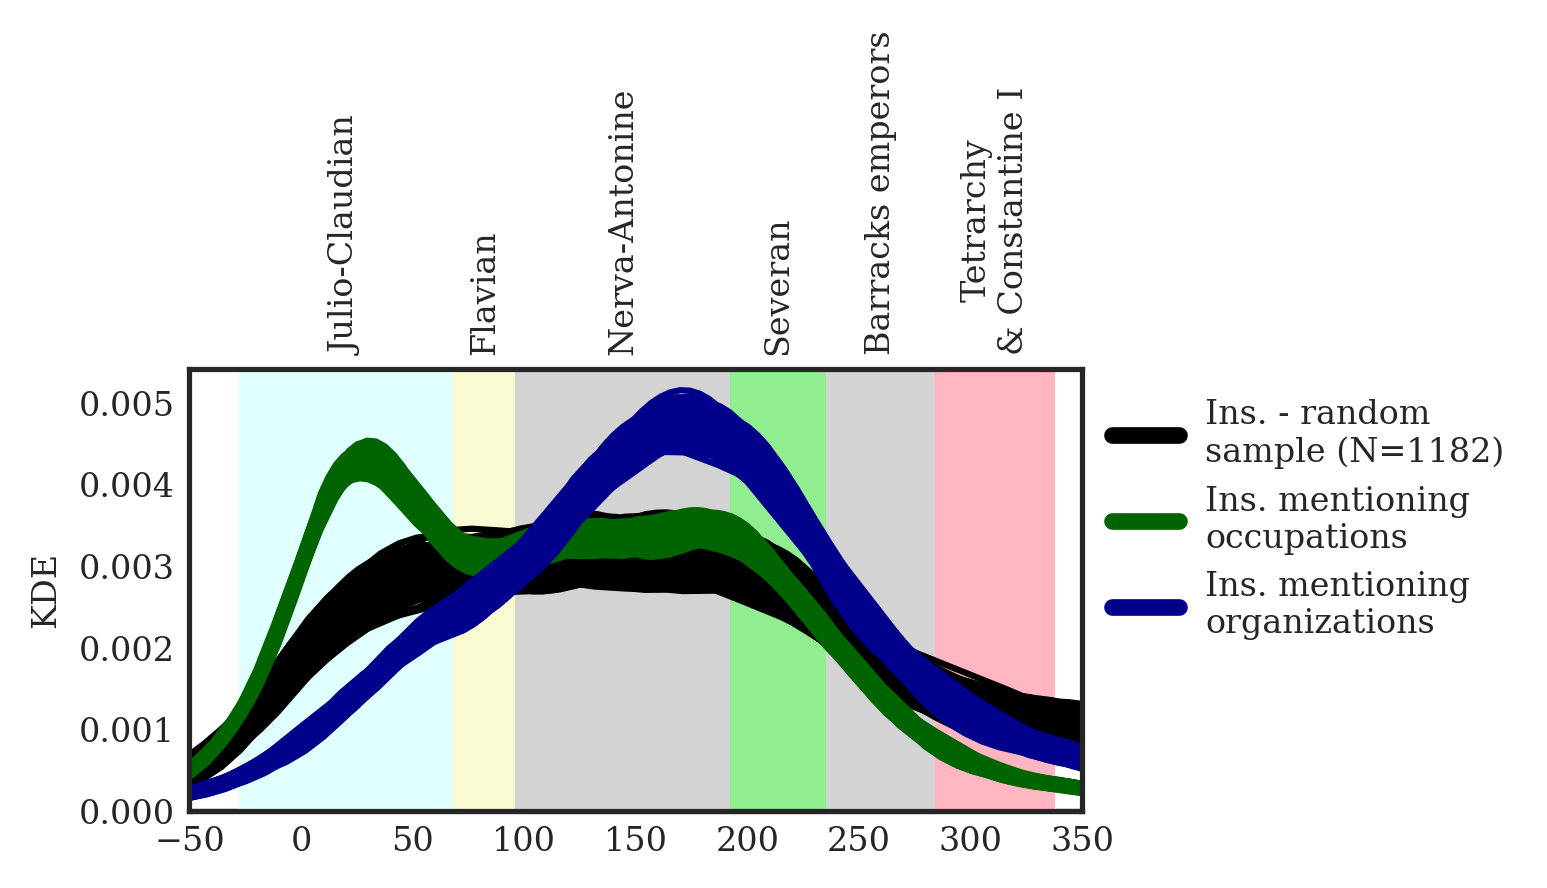

In [86]:
%%time 
# timeconsuming, because of the KDE involved

plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

#positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[5.2, 3], tight_layout=True)

for period, color in zip(periods.keys(), colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")


for data in var_data_edhcs[:1000]:
    # to be based on sample or not... 
    data = random.sample(data, k=sample_size)
    sns.kdeplot(data, ax=ax, color="black") #, alpha=0.5)   
    
for data in var_data_occups[:1000]:
    sns.kdeplot(data, ax=ax, color="darkgreen") #, alpha=0.5)
    
for data in var_data_orgs[:1000]:
    sns.kdeplot(data, ax=ax, color="darkblue") # , alpha=0.5)
 

    
ax.set_xlim(-50,350)



ax.set_ylabel("KDE")

# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")


markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in ["black", "darkgreen", "darkblue"]]
plt.legend(markers, ["Ins. - random\nsample (N={0})".format(str(sample_size)), "Ins. mentioning\noccupations", "Ins. mentioning\norganizations"], bbox_to_anchor=(1, 1), loc='upper left')


In [87]:
sddk.write_file(figpath + "comparing_distributions_kde.eps", fig, conf)
sddk.write_file(figpath + "comparing_distributions_kde.png", fig, conf)

A file with the same name ("comparing_distributions_kde.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/comparing_distributions_kde.eps"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/comparing_distributions_kde.png"


# Statistical comparison


We use two-sample Kolmogorov-Smirnov test, which checks whether  two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal).  

We employ it to compare distribution of all iscriptions mentioning an occupation/organization against a distribution based on a random sample of inscriptions of the same length. We repeat this procedure for all dating simulations and evaluate the consinstency of the findings.

In [90]:
# one variant example
scipy.stats.kstest(var_data_orgs[0], random.sample(var_data_edhcs[0], k=len(var_data_orgs[0])))

KstestResult(statistic=0.15397631133671744, pvalue=1.2222280197711046e-12)

In [92]:
random.seed(0)

p_values, KS_stats = [], []
for var_n in range(len(var_data_edhcs)):
    ks, p = scipy.stats.ks_2samp(var_data_orgs[var_n], random.sample(var_data_edhcs[var_n], k=len(var_data_orgs[var_n])))
    KS_stats.append(ks)
    p_values.append(p)
len([p for p in p_values if p < 0.001])

1000

In [93]:
random.seed(0)

p_values, KS_stats = [], []
for var_n in range(len(var_data_edhcs)):
    ks, p = scipy.stats.ks_2samp(var_data_occups[var_n], random.sample(var_data_edhcs[var_n], k=len(var_data_occups[var_n])))
    KS_stats.append(ks)
    p_values.append(p)
len([p for p in p_values if p < 0.001])

1000

# Inscriptions over time: Word counts & character counts

In [105]:
# functions to be used to extract interesting information from timeblocks simulation data

def wordcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()

def wordcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum() / len(timeblock_df)

def charcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()

def charcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum() / len(timeblock_df)

def unique_words(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock"""
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words

def unique_words_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock
    in proportion to total number of words"""
    wordcount = timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words / wordcount

def extract_ngrams(text, width=4):
    """extracts character ngrams from a string of given width
    returns: list of ngrams"""
    char_ngrams = ["".join(ngram) for ngram in list(ngrams(str(text), width))]
    return char_ngrams

def unique_ngrams(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique)

def unique_ngrams_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock
    in proportion to total number of characters"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique) / charcount

In [ ]:
%%time
wordcounts_data = tempun.sim_data_by_function(EDHCSg, 100, [-50, 350, 50], wordcount) 
wordcounts_avg_data = tempun.sim_data_by_function(EDHCSg, 100, [-50, 350, 50], wordcount_avg) 
charcounts_data = tempun.sim_data_by_function(EDHCSg, 100, [-50, 350, 50], charcount) 
charcounts_avg_data = tempun.sim_data_by_function(EDHCSg, 100, [-50, 350, 50], charcount_avg) 
unique_words_data = tempun.sim_data_by_function(EDHCSg, 100, [-50, 350, 50], unique_words)
unique_ngrams_data = tempun.sim_data_by_function(EDHCSg, 100, [-50, 350, 50], unique_ngrams)

In [112]:
unique_ngrams_data = tempun.sim_data_by_function(EDHCSg, 100, [-50, 350, 50], unique_ngrams)

In [113]:
sim_data_list = [
    (EDHCS_complete_simulations, "(A) inscription counts", "count"),
    (wordcounts_data, "(B) word counts", "count"),
    (charcounts_data,  "(C) character counts", "character count"),
    (unique_words_data, "(D) unique words", "count"),
    (unique_ngrams_data, "(E) unique character four-grams", "count"),
    (charcounts_avg_data, "(F) avg. char. counts per ins.", "avr. char. count")]
    #(wordcounts_avg_data, "(E) EDH - average wordcounts per inscription", "avr. wordcount"),



[0.0, 5000.0, 10000.0, 15000.0, 20000.0, 25000.0]
[0.0, 100000.0, 200000.0, 300000.0, 400000.0]
[0.0, 500000.0, 1000000.0, 1500000.0, 2000000.0, 2500000.0]
[10000.0, 20000.0, 30000.0, 40000.0]
[20000.0, 30000.0, 40000.0, 50000.0, 60000.0]


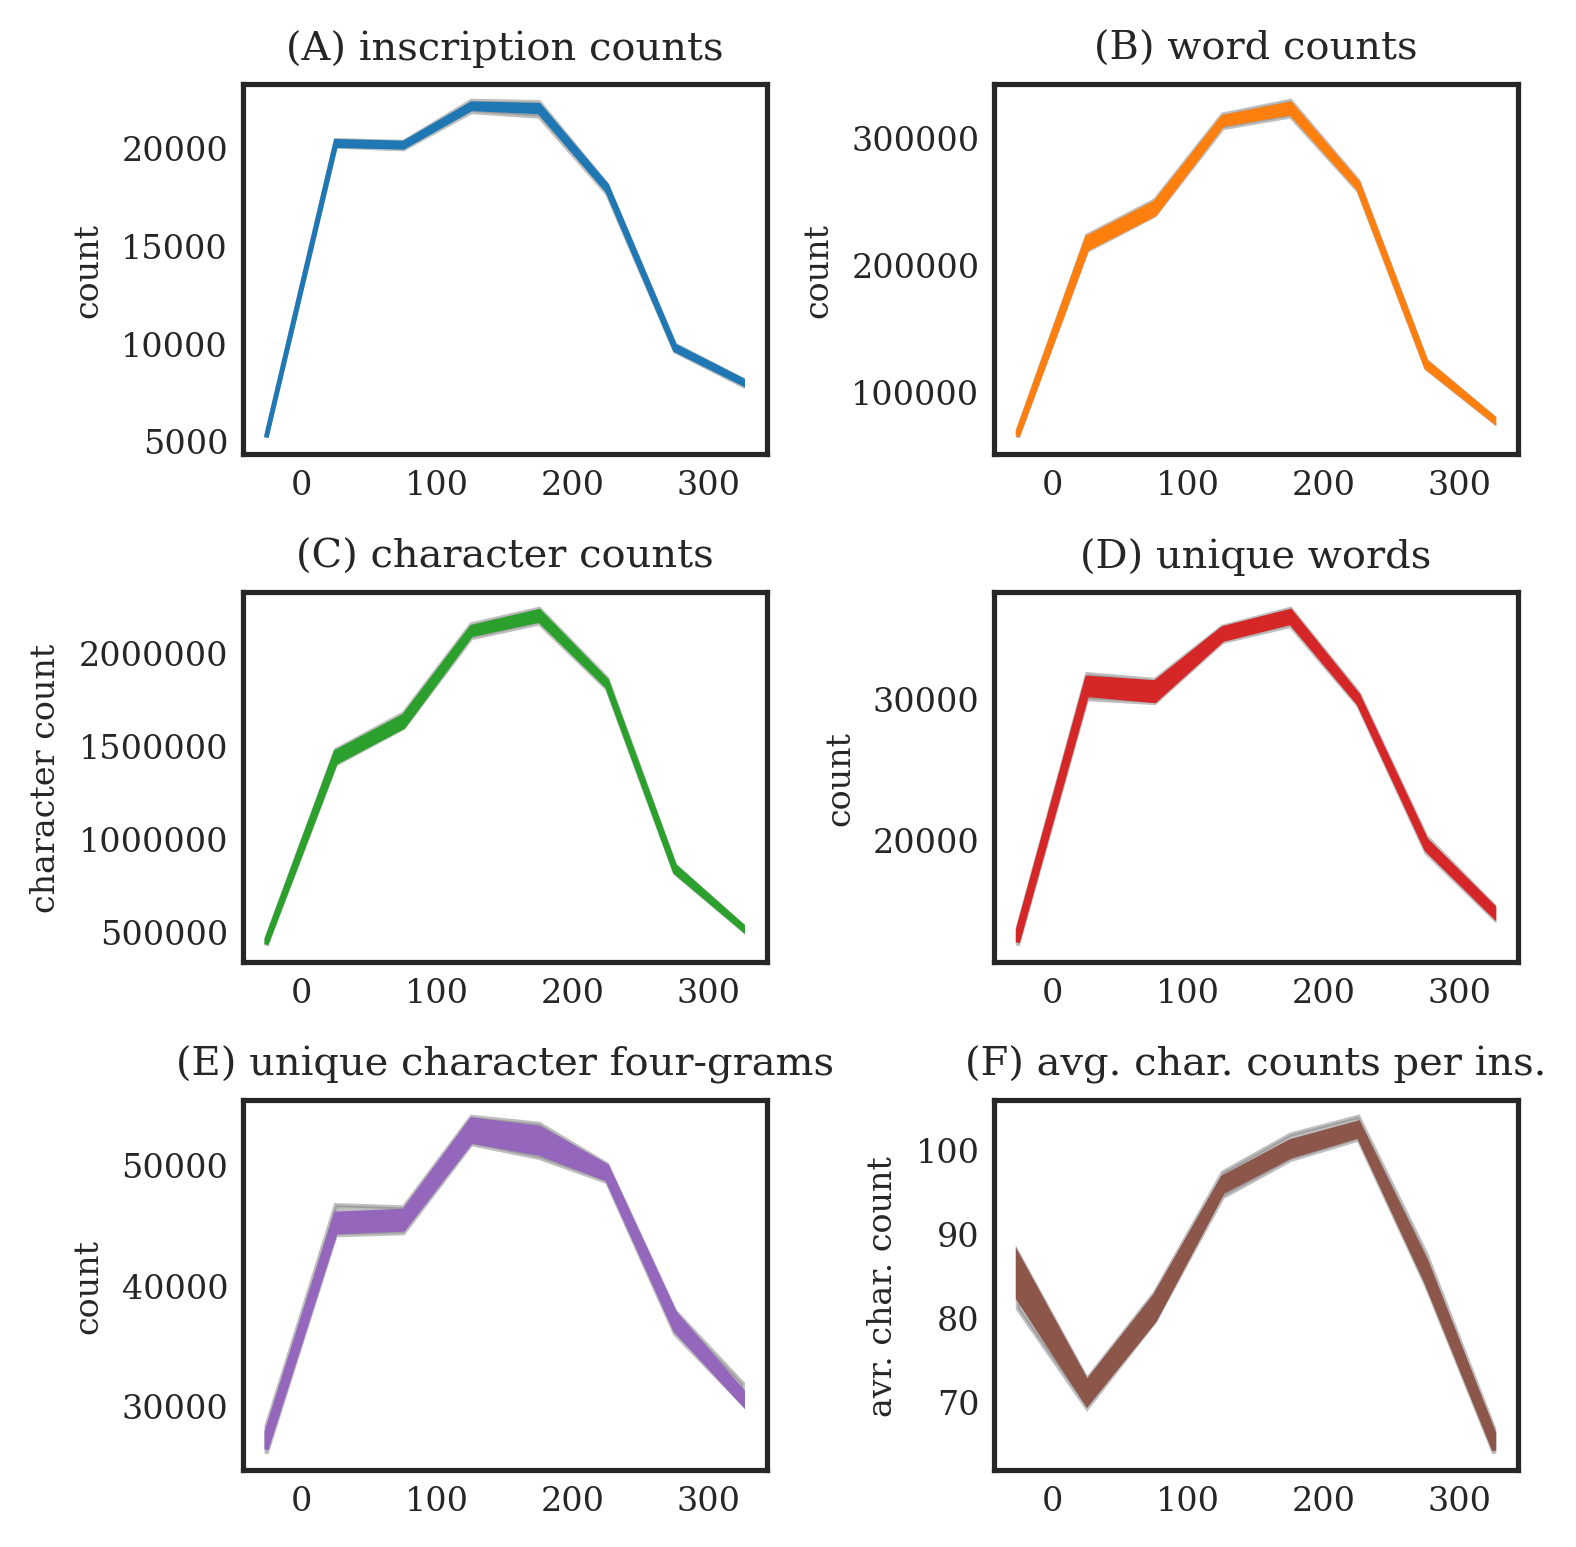

In [115]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

mpl.rcParams["axes.formatter.limits"] = [-5, 10]

fig, axs  = plt.subplots(3, 2, figsize=(5.2, 5.2), tight_layout=True)

for sim_data, ax, color in zip(sim_data_list, axs.ravel(), tab_colors_list[:len(sim_data_list)]):
    tempun.plot_timeblocks_data(sim_data[0], ax, color)
    ax.set_title(sim_data[1])
    ax.set_ylabel(sim_data[2])
    if max([el[1] for el in sim_data[0][0]]) > 5000:
        ticks = list(ax.get_yticks())
        print(ticks)
        ticks_K = [str(int(int(tick) / 1000)) + "K" if tick != 0 else tick for tick in ticks]
        #ax.set_yticklabels(ticks_K)
# to hide an axis:
#axs[3,1].set_axis_off()       

In [116]:
sddk.write_file(figpath + "various_ins_counts_temporal.png", fig, conf)
sddk.write_file(figpath + "various_ins_counts_temporal.eps", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/various_ins_counts_temporal.png"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/various_ins_counts_temporal.eps"


# Inscription types over time

In [34]:
simulations_by_type_len = []

for ins_type in EDH["type_of_inscription_clean"].unique():
    if ins_type != "NULL":
        subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type]
        simulations_by_type_len.append((ins_type, len(subset_df)))
simulations_by_type_len = sorted(simulations_by_type_len, key = lambda x: x[1], reverse=True)
simulations_by_type_len

[('epitaph', 27953),
 ('votive inscription', 14044),
 ('owner/artist inscription', 5185),
 ('honorific inscription', 3999),
 ('building/dedicatory inscription', 3307),
 ('mile-/leaguestone', 1730),
 ('identification inscription', 1574),
 ('acclamation', 533),
 ('military diploma', 500),
 ('list', 360),
 ('defixio', 309),
 ('label', 289),
 ('public legal inscription', 248),
 ('boundary inscription', 246),
 ('elogium', 143),
 ('letter', 121),
 ('seat inscription', 87),
 ('prayer', 56),
 ('private legal inscription', 45),
 ('assignation inscription', 16),
 ('calendar', 14),
 ('adnuntiatio', 3)]

In [35]:
simulations_by_type = []

for ins_type_tup in simulations_by_type_len[:10]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    simulations = timeblocks_from_randoms(subset_df, "random_dates", [-200, 600, 100])
    ins_type_N =len(subset_df)
    simulations_by_type.append([ins_type_tup[0],ins_type_N, simulations]) 
simulations_by_type = sorted(simulations_by_type, key=lambda x: x[1], reverse=True)

In [36]:
simulations_by_type = sorted(simulations_by_type, key=lambda x: x[1], reverse=True)

In [37]:
simulations_by_type[4][1]

3307

In [451]:
date_vars_by_instypes = []
for ins_type_tup in simulations_by_type_len[:10]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    date_vars = []
    for n in range(100):
        date_vars.append([date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 2min 22s, sys: 3min 18s, total: 5min 41s
Wall time: 33.5 s


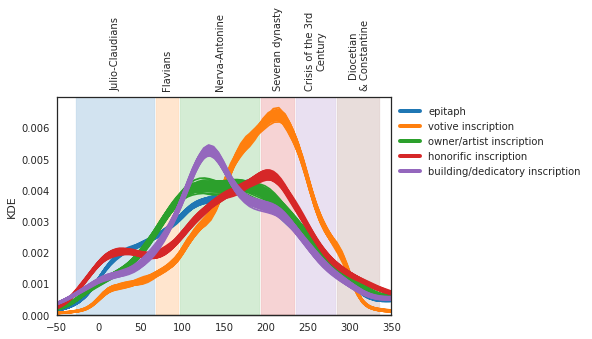

In [457]:
%%time 
# timeconsuming, because of the KDE involved
labels=[key for key in periods.keys()]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[6,4])

labels_ins = [tup[0] for tup in simulations_by_type_len]

for period, color in zip(periods.keys(), tab_colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color, alpha=0.2)#, linestyles="dashed", color="red")

for instype_data, color in zip(date_vars_by_instypes[:5], tab_colors_list[:5]):
    for sim_var in instype_data:
        sns.kdeplot(sim_var, ax=ax, color=color)
        

ax.set_xlim(-50,350)
ax.set_ylabel("KDE")

# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")

markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in tab_colors_list[:len(simulations_by_type)]]
plt.legend(markers, labels_ins[:5], bbox_to_anchor=(1, 1), loc='upper left')


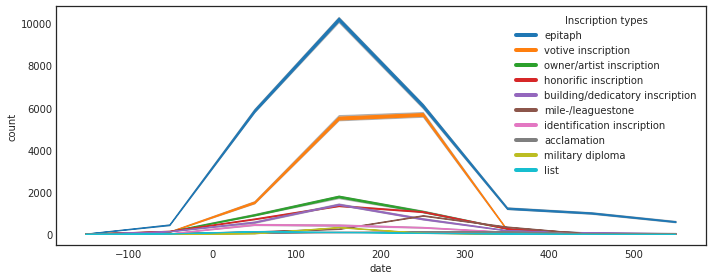

In [40]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, ax  = plt.subplots(figsize=(10, 4), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type, tab_colors_list[:len(simulations_by_type)]):
    plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)
    
ax.set_xlabel("date")
ax.set_ylabel("count")
#ax.set_title("EDH - 10 most common inscription types over time")
 
markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in tab_colors_list[:len(simulations_by_type)]]
plt.legend(markers, [tup[0] for tup in simulations_by_type], numpoints=1,  title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

In [220]:
sddk.write_file("SDAM_data/social_diversity/EDH_inscription_types_temporal.png", fig, conf)

A file with the same name ("EDH_inscription_types_temporal.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_inscription_types_temporal.png"


# Occupations & organizations over inscription types

In [76]:
# N of occuptions and N of organization per inscription category
ins_types_occs_orgs = []
for ins_type_tup in simulations_by_type_len:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    occ_N = subset_df["occups_N"].sum()
    orgs_N = subset_df["organizations_N"].sum()
    ins_types_occs_orgs.append([ins_type_tup[0] + " (N={0})".format(len(subset_df)), occ_N, orgs_N])
    print("inscription type: {0}, N of occupations: {1}, N of organizations: {2}".format(ins_type_tup[0], str(occ_N), str(orgs_N)))

inscription type: epitaph, N of occupations: 565, N of organizations: 282
inscription type: votive inscription, N of occupations: 345, N of organizations: 150
inscription type: owner/artist inscription, N of occupations: 24, N of organizations: 0
inscription type: honorific inscription, N of occupations: 218, N of organizations: 87
inscription type: building/dedicatory inscription, N of occupations: 103, N of organizations: 48
inscription type: mile-/leaguestone, N of occupations: 0, N of organizations: 0
inscription type: identification inscription, N of occupations: 12, N of organizations: 0
inscription type: acclamation, N of occupations: 5, N of organizations: 0
inscription type: military diploma, N of occupations: 77, N of organizations: 0
inscription type: list, N of occupations: 47, N of organizations: 16
inscription type: defixio, N of occupations: 5, N of organizations: 5
inscription type: label, N of occupations: 0, N of organizations: 0
inscription type: public legal inscrip

In [77]:
pd.DataFrame(ins_types_occs_orgs, columns=["inscription type", "occupations", "organisations"])

,inscription type,occupations,organisations
0,epitaph (N=27953),565,282
1,votive inscription (N=14044),345,150
2,owner/artist inscription (N=5185),24,0
3,honorific inscription (N=3999),218,87
4,building/dedicatory inscription (N=3307),103,48
5,mile-/leaguestone (N=1730),0,0
6,identification inscription (N=1574),12,0
7,acclamation (N=533),5,0
8,military diploma (N=500),77,0
9,list (N=360),47,16


In [51]:
types, occups_freqs, orgs_freqs = [], [], [] 

for ins_type_tup in simulations_by_type_len[:10][::-1]: # for horizontal bar below, we need the list in reverse order, therefore: [::-1]
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    subset_wordcount = wordcount(subset_df).sum()
    types.append(ins_type_tup[0])
    occups_freqs.append(subset_df["occups_N"].sum() / subset_wordcount * 1000)
    orgs_freqs.append(subset_df["organizations_N"].sum() / subset_wordcount * 1000)

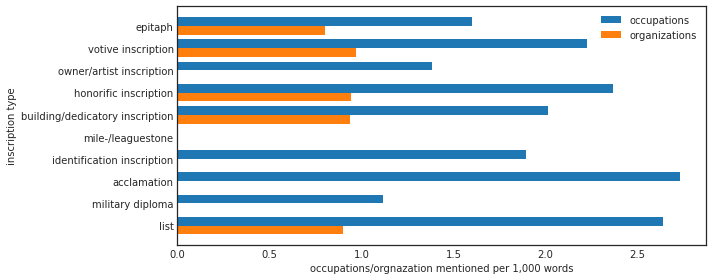

In [52]:
fig, ax  = plt.subplots(figsize=(10, 4), tight_layout=True)

y = np.arange(len(types))
height = 0.4

ax.barh(y + height/2, occups_freqs, height, label="occupations", color="tab:blue") #, color=tab_colors_list[:len(simulations_by_type)])
ax.barh(y - height/2, orgs_freqs, height, label="organizations", color="tab:orange") #, color=tab_colors_list[:len(simulations_by_type)])

ax.set_yticks(y) #y_pos, types)
ax.set_yticklabels(types) #, rotation="vertical")
ax.set_xlabel("occupations/orgnazation mentioned per 1,000 words")
ax.set_ylabel("inscription type")
ax.legend()

In [120]:
sddk.write_file("SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png", fig, conf)

A file with the same name ("EDH_occupsorgs_by_instypes.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png"


# Occupations & organizations together

In [71]:
len(EDH[EDH["organizations_N"]>0])

727

In [72]:
len(EDH[EDH["occups_N"]>0])

1913

In [75]:
len(EDH[(EDH["occups_N"]>0) & (EDH["organizations_N"]>0)])

231

In [76]:
EDH["occupsorgs"] = EDH.apply(lambda row: row["occups"] + row["organizations"], axis=1)

In [77]:
EDH["occupsorgs_N"] = EDH["occupsorgs"].apply(len)

In [78]:
EDH["occupsorgs_N"].sum()

3136

In [79]:
occupsorgs_list = [el for el in EDH["occupsorgs"].tolist() if len(el) > 0]
occupsorgs_list

[['corpus'],
 ['negotiator'],
 ['fullo'],
 ['dendrophorus'],
 ['aerarius', 'corpus'],
 ['mulionus'],
 ['mulionus'],
 ['collegium'],
 ['corpus'],
 ['faber'],
 ['navalis', 'faber', 'corpus'],
 ['subaedianus',
  'subaedianus',
  'faber',
  'faber',
  'collegium',
  'corpus',
  'corpus'],
 ['faber'],
 ['argentarius', 'coactor'],
 ['negotiator'],
 ['negotiator'],
 ['scriba', 'corpus', 'corpus'],
 ['curator'],
 ['corpus'],
 ['pomarius'],
 ['sagittarius', 'sagittarius'],
 ['aerarius'],
 ['curator'],
 ['arcarius'],
 ['curator', 'faber'],
 ['sagittarius', 'faber'],
 ['copo'],
 ['collegium', 'collegium'],
 ['faber', 'collegium'],
 ['sagittarius', 'sagittarius'],
 ['sagittarius', 'sagittarius'],
 ['sagittarius', 'sagittarius'],
 ['sagittarius', 'sagittarius'],
 ['faber'],
 ['imaginarius',
  'scriba',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'corpus',
  'corp

In [102]:
len(occupsorgs_list)

2409

In [90]:
dictionary = corpora.Dictionary(occupsorgs_list)

In [93]:
dictionary = corpora.Dictionary(occupsorgs_list)
vocabulary = [el[1] for el in dictionary.items()]
vocabulary[:10]

['corpus',
 'negotiator',
 'fullo',
 'dendrophorus',
 'aerarius',
 'mulionus',
 'collegium',
 'faber',
 'navalis',
 'subaedianus']

In [109]:
orgs = ["colegium", "collegium", "collegiatus", "collegius", "collega", "concilium", "conlegium", "collegatarius", "collegiarius", "corpus", "corporatus", "sociatio", "societas", "sodalitas", "sodalicium"]

In [115]:
for org in orgs:
    try:
        org_id = dictionary.token2id[org]
        org_freq = dictionary.cfs[org_id]
        print("'{0}' count: {1}".format(org, org_freq))
    except:
        print("'{0}' not found".format(org))

'colegium' count: 1
'collegium' count: 452
'collegiatus' count: 11
'collegius' count: 10
'collega' count: 60
'concilium' count: 12
'conlegium' count: 13
'collegatarius' not found
'collegiarius' count: 1
'corpus' count: 288
'corporatus' count: 11
'sociatio' not found
'societas' count: 5
'sodalitas' not found
'sodalicium' count: 4


In [106]:
terms_dfs = [dictionary.dfs[n] for n in range(len(dictionary))]

In [119]:
vec_bow = CountVectorizer(vocabulary=vocabulary)
bow = vec_bow.fit_transform([" ".join(list(set(el))) for el in occupsorgs_list]) ### run the model
vec_bow.get_feature_names()
cooc  = bow.T * bow

cooc.setdiag(terms_dfs) 

cooc_df = pd.DataFrame(cooc.todense(), columns=vocabulary, index=vocabulary) # / len(docs)
cooc_df

/home/kasev/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



,corpus,negotiator,fullo,dendrophorus,aerarius,mulionus,collegium,faber,navalis,subaedianus,...,lignarius,arenarius,uctor,metator,sculptor,saccarius,caupo,macellarius,faber ferrarii,quadratarius
corpus,251,0,0,0,6,0,13,6,2,1,...,0,0,0,1,0,0,0,0,0,0
negotiator,0,51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fullo,0,0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dendrophorus,0,0,0,26,0,0,9,7,0,0,...,0,0,0,0,0,0,0,0,0,0
aerarius,6,0,0,0,95,0,4,8,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
saccarius,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
caupo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
macellarius,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
faber ferrarii,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [128]:
cooc_df[cooc_df["collegium"]>0].sort_values("collegium", ascending=False)["collegium"][1:]

faber           149
corpus           13
tignarius        12
dendrophorus      9
scriba            7
collega           5
curator           5
aerarius          4
cerarius          3
vexillarius       3
lapidarius        2
utricularius      2
scaenicus         2
medicus           2
mulionus          2
collegiatus       2
corporatus        2
scriptor          1
lanionus          1
lotorus           1
unguentarius      1
utriclarius       1
dolabrarius       1
navicularius      1
nauclerus         1
tegularius        1
fabriciensis      1
nummularius       1
clibanarius       1
lyntrarius        1
tibicinus         1
anularius         1
venator           1
structor          1
negotians         1
vinarius          1
conlegium         1
mensor            1
imaginarius       1
coactor           1
argentarius       1
subaedianus       1
focarius          1
Name: collegium, dtype: int64

In [129]:
cooc_df[cooc_df["corpus"]>0].sort_values("corpus", ascending=False)["corpus"][1:]

collegium        13
faber             6
curator           6
aerarius          6
mensor            3
navalis           2
scriba            2
navicularius      2
concilium         1
lyntrarius        1
nummularius       1
parasitus         1
intestinus        1
conditor          1
hastifer          1
conquiliarius     1
stuppator         1
scaenicus         1
aurifex           1
suarius           1
collegiatus       1
negotians         1
corporatus        1
collega           1
imaginarius       1
sagittarius       1
subaedianus       1
metator           1
Name: corpus, dtype: int64

# Occupations by industry types

In [185]:
occupations_df = get_as_dataframe(occupations.worksheet("Occupation"))
occupations_df = occupations_df[['Term', 'gen_sg', 'Vocab_nom_sg', 'Source', 'Category', 'Subcategory','Translation_eng']]
occupations_df = occupations_df.dropna(thresh=5)
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Category"]))

In [183]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
    
EDH["occups_cats"] = EDH["occups"].apply(cat_for_occup)

In [184]:
occups_cats_list = [el for sublist in EDH["occups_cats"].tolist() for el in sublist]
print(len(occups_cats_list))
print(nltk.FreqDist(occups_cats_list).most_common(30))

2268
[('Metal-Working', 741), ('Miscellaneous Services', 357), ('Managerial', 283), ('Building', 151), ('Retail', 132), ('Education', 118), ('Performing Arts', 113), ('Food-Production', 93), ('Clothing', 83), ('Transport', 70), ('Finance', 41), ('Plastic Arts', 30), ('Household Goods', 20), ('Food-Retail', 19), ('Water-Management', 7), ('Death-care sector', 4), ('Glass-Working', 3), ('Unclear meaning', 2), ('Fuel / Raw material', 1)]


# Occupations & Organizations over centuries

In [62]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["occups_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

def orgs_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["organizations_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

# various metrics on the level of timeblocks
def occups_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["occups_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

def orgs_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["organizations_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

# various metrics on the level of timeblocks
def unique_occups(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    return unique_occups

# unique occups / inscriptions
def unique_occups_ins_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    return unique_occups / len(timeblock_df)


# various metrics on the level of timeblocks
def unique_occups_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_occups / unique_words

In [63]:
occups_counts = sim_data_by_function(EDH, 100, [-200, 600, 100], occups_count) 
occups_ins_ratio = sim_data_by_function(EDH, 100, [-200, 600, 100], occups_inscriptions_ratio)
occups_TF_data = sim_data_by_function(EDH, 100, [-200, 600, 100], occups_cumulTF) 
unique_occups_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_occups) 
unique_occups_ratio_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_occups_ratio) 
unique_occups_ins_ratio_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_occups_ins_ratio)

In [64]:
orgs_counts = sim_data_by_function(EDH, 100, [-200, 600, 100], orgs_count) 
orgs_ins_ratio = sim_data_by_function(EDH, 100, [-200, 600, 100], orgs_inscriptions_ratio)
orgs_TF_data = sim_data_by_function(EDH, 100, [-200, 600, 100], orgs_cumulTF) 

In [65]:
sim_data_list = [
    ([occups_counts, orgs_counts], "(A) EDH - occupations/organizations count", "occupation mentions count"),
    ([occups_ins_ratio, orgs_ins_ratio], "(B) EDH - occupations/organizations per 100 inscriptions", "inscriptions/organizations"),
    ([occups_TF_data, orgs_TF_data], "(C) EDH - occupations/organizations per 1000 words", "occupations/organizatations"),
    ([unique_occups_data], "(D) EDH - unique occupations", "unique occupations"),
    ([unique_occups_ratio_data], "(E) EDH - unique occupations per 1000 unique words", "unique occupations"),
    ([unique_occups_ins_ratio_data], "(F) EDH - unique occupations per 100 inscriptions", "unique occupations")     
]

In [66]:
unique_occups_data[0]

[((-200, -101), 2),
 ((-100, -1), 20),
 ((1, 100), 86),
 ((101, 200), 94),
 ((201, 300), 102),
 ((301, 400), 31),
 ((401, 500), 13),
 ((501, 600), 5)]

In [67]:
tab_colors_list = [col for col in tab_colors_list if col != "tab:gray"]  

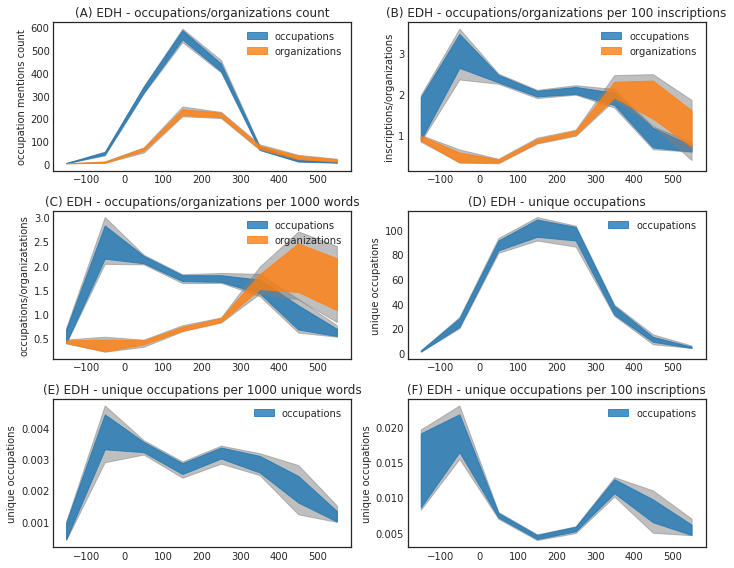

In [69]:
plt.style.use("seaborn-white")

fig, axs  = plt.subplots(3, 2, figsize=(10, 8), tight_layout=True)
n = 0
for sim_data, ax in zip(sim_data_list, axs.ravel()):
        for plot_data, color, label in zip(sim_data[0], ["tab:blue", "tab:orange"], ["occupations", "organizations"]):
            plot_timeblocks_data(plot_data, ax, color, label=label, alpha=0.8)
            n += 1
        ax.set_title(sim_data[1])
        ax.set_ylabel(sim_data[2])
        ax.legend()

In [222]:
sddk.write_file("SDAM_data/social_diversity/EDH_occupsorgs_temporal.png", fig, conf)

A file with the same name ("EDH_occupsorgs_temporal.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occupsorgs_temporal.png"


# Occupations & organizations by periods

In [299]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudians" : {"startdate": -27, "enddate" : 67},
    "Flavians" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 193},
    # or:
    #"5 good emperors" : {"startdate": 97, "enddate": 180},
    #"Commodus" : {"startdate" : 181, "enddate" : 193},
    "Severan dynasty" : {"startdate": 194, "enddate": 235},
    "Crisis of the 3rd\nCentury" : {"startdate" : 236, "enddate" : 284},
    "Diocetian\n& Constantine" : {"startdate" : 285, "enddate" : 337}
    }
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 67), (69, 96), (97, 193), (194, 235), (236, 284), (285, 337)]

In [300]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["occups_N"].sum()
    return occups_N_sum

def orgs_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["organizations_N"].sum()
    return occups_N_sum

In [301]:
%%time

# time consuming, apply carefully
#occups_counts = sim_data_by_function(EDH, 1000, timeblocks_periods, occups_count) 
occups_ins_ratio = sim_data_by_function(EDH, 1000, timeblocks_periods, occups_per_1K_ins)
#orgs_counts = sim_data_by_function(EDH, 1000, timeblocks_periods, orgs_count) 
orgs_ins_ratio = sim_data_by_function(EDH, 1000, timeblocks_periods, orgs_per_1K_ins)

CPU times: user 8min 41s, sys: 6.2 s, total: 8min 47s
Wall time: 8min 34s


In [302]:
occups_ins_ratio[2]

[((-27, 67), 19),
 ((69, 96), 21),
 ((97, 193), 34),
 ((194, 235), 14),
 ((236, 284), 29),
 ((285, 337), 28)]

In [303]:
def simulations_merged(simulation_data):
    merged_data = []
    for n in range(len(simulation_data[0])): # choose the first simulation to get the length 
        merged_data.append((simulation_data[0][n][0], [sim[n][1] for sim in simulation_data]))
    return merged_data

occups_ratios_merged = simulations_merged(occups_ins_ratio)
orgs_ratios_merged = simulations_merged(orgs_ins_ratio)

In [304]:
occups_ratios_merged = simulations_merged(occups_ins_ratio)
orgs_ratios_merged = simulations_merged(orgs_ins_ratio)

In [305]:
[key for key in periods.keys()]

['Julio-Claudians',
 'Flavians',
 'Nerva-Antonine',
 'Severan dynasty',
 'Crisis of the 3rd\nCentury',
 'Diocetian\n& Constantine']

In [306]:
[abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]

[94, 27, 96, 41, 48, 52]

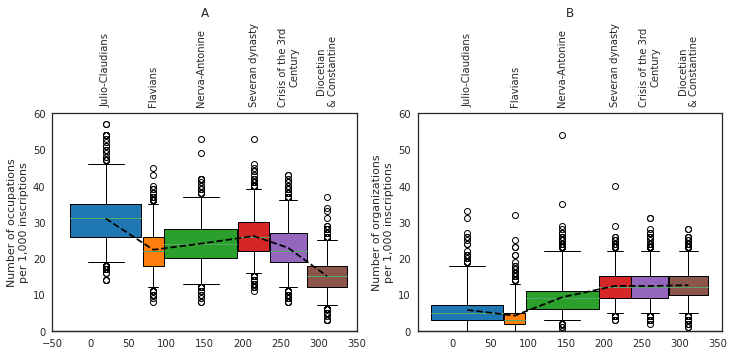

In [347]:
# number of occupations/organizizations per 1,000 randomly sampled inscriptions. The samples are with replacement. Each sample is based on different dating simulation. 

plt.style.use("seaborn-white")#-white")

labels=[key for key in periods.keys()]
widths = [abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]


fig, [ax1, ax2] = plt.subplots(1,2, figsize=[12,4])

data1 = [tup[1] for tup in occups_ratios_merged]
means1 = [np.mean(tup[1]) for tup in occups_ratios_merged]

bplot1 = ax1.boxplot(data1, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.plot(positions, means1, color="black", linestyle="dashed", zorder=10)


ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.set_ylim(0, 60)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
ax1.secondary_xaxis("bottom")
ax1.set_xlim(-50, 350)



data2 = [tup[1] for tup in orgs_ratios_merged]
means2 = [np.mean(tup[1]) for tup in orgs_ratios_merged]

bplot2 = ax2.boxplot(data2, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.plot(positions, means2, color="black", linestyle="dashed", zorder=10)

ax2.set_title("B")
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")
ax2.set_ylim(0, 60)
ax2.xaxis.set_tick_params(rotation=90)
ax2.xaxis.tick_top()
ax2.secondary_xaxis("bottom")

# fill with colors
colors =tab_colors_list[:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)